## packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
% matplotlib inline

## Data visualisation

In [4]:
raw_data=pd.read_csv('Telco.csv')
#raw_data.info()
del raw_data['customerID']

In [5]:
raw_data['TotalCharges']=raw_data['TotalCharges'].convert_objects(convert_numeric=True)
raw_data.dropna(inplace=True)
raw_data.reset_index(inplace=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [6]:
# let's work with artificially resampled data for the minority 
minority=raw_data[raw_data.Churn=='Yes']
majority=raw_data[raw_data.Churn=='No']
df_minority_upsampled = resample(minority, 
                                 replace=True,     
                                 n_samples=len(majority),    
                                 random_state=123)
data_bal=pd.concat([df_minority_upsampled,majority])
data_bal=data_bal.reset_index()
del data_bal['index']

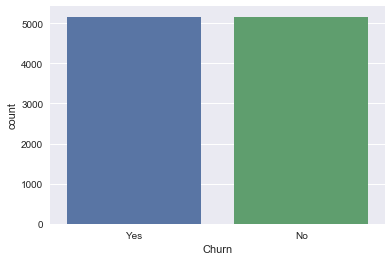

In [7]:
sns.countplot(data_bal['Churn'])

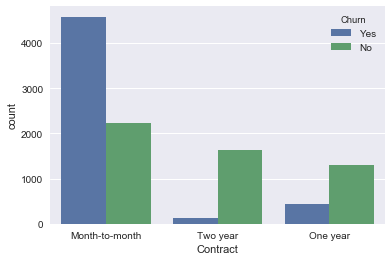

In [8]:
sns.countplot(x='Contract',data=data_bal,hue='Churn')

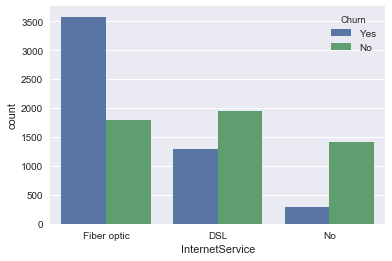

In [9]:
sns.countplot(x='InternetService',data=data_bal,hue='Churn')

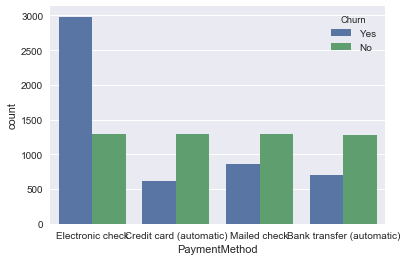

In [10]:
sns.countplot(x='PaymentMethod',data=data_bal,hue='Churn')
# churn très élevés pour les electronic check

## Data mining

### convert cat to dummies

In [11]:
categorical_var=['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [12]:
# convert the categorical variables
data=pd.get_dummies(data_bal[categorical_var],drop_first=True)
data['Churn']=data_bal['Churn']
data['MonthlyCharges']=data_bal['MonthlyCharges']
data['tenure']=data_bal['tenure']
data['TotalCharges']=data_bal['TotalCharges']

### remove colinearity across explanatory variables

In [13]:
def remove_col_var(data,obj,thres):
    d={}
    for col in list(data.drop(obj,axis=1).columns):
        d[col]=np.sum(data.drop(obj,axis=1).corr()[col].apply(lambda z : (abs(z)>thres)))
    corr_var=[key for key in d.keys() if d[key]!=1]
    cols=data.drop(obj,axis=1).columns
    dropped=[]
    for col in corr_var:
        L=list(data.corr()[abs(data.corr()[col])>thres][col].index)
        l=list(pd.DataFrame({'value':data.corr()[abs(data.corr()[col])>thres][col]},index=L).
               sort_values(by='value', axis=0, ascending=False).index) 
        if len(l)>2:
            l=l[1:-1]
            if l:
                cols=[cols[i] for i in range(len(cols)) if cols[i] not in l]
                dropped.extend(l)
        if len(l)==2:
            l=l[1:]
            cols=[cols[i] for i in range(len(cols)) if cols[i] not in l]
            dropped.extend(l)
    cols.append(obj)        
    return data[cols]

In [14]:
#sns.heatmap(data.corr())
# the explanatory variables are less correlated now

### keep most important features

In [15]:
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
def keep_important_features(data,obj,thres):
    y=data[obj].apply(lambda z: int(z=='Yes'))
    X=data.drop(obj,axis=1)
    rlasso = RandomizedLasso(alpha=0.04)
    rlasso.fit(X, y)
    ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), X.columns)
    lr = LinearRegression(normalize=True)
    lr.fit(X,y)
    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, verbose =3 )
    rfe.fit(X,y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)),  X.columns, order=-1)
    # Using Linear Regression
    lr = LinearRegression(normalize=True)
    lr.fit(X,y)
    ranks["LinReg"] = ranking(np.abs(lr.coef_),  X.columns)

    # Using Ridge 
    ridge = Ridge(alpha = 7)
    ridge.fit(X,y)
    ranks['Ridge'] = ranking(np.abs(ridge.coef_),  X.columns)

    # Using Lasso
    lasso = Lasso(alpha=.05)
    lasso.fit(X, y)
    ranks["Lasso"] = ranking(np.abs(lasso.coef_),  X.columns)

    r={}
    for name in X.columns:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    cols_to_keep=meanplot[meanplot['Mean Ranking']>=thres]['Feature']
    l=list(cols_to_keep)
    l.append(obj)
    return data[l]

### Final data set

In [16]:
data_f=remove_col_var(keep_important_features(data,'Churn',0.04),'Churn',0.85)

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.

In [17]:
X=data_f.drop('Churn',axis=1)
y=data_f['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## ML modeling

### log regression

In [18]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

In [19]:
print(confusion_matrix(y_test,predictions))

[[1160  399]
 [ 320 1219]]


In [20]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

         No       0.78      0.74      0.76      1559
        Yes       0.75      0.79      0.77      1539

avg / total       0.77      0.77      0.77      3098



### tree

In [21]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

         No       0.92      0.83      0.87      1559
        Yes       0.84      0.93      0.88      1539

avg / total       0.88      0.88      0.88      3098



[[1295  264]
 [ 110 1429]]


## Interpretation

In [22]:
from treeinterpreter import treeinterpreter as ti

In [54]:
test=X_train.iloc[0:3]

In [52]:
test=np.array(test).reshape(1, -1)

In [55]:
rfc.predict(test)
prediction, bias, contributions = ti.predict(rfc, test)

In [56]:
prediction

array([[ 0.  ,  1.  ],
       [ 0.03,  0.97],
       [ 0.9 ,  0.1 ]])

In [50]:
raw_data.iloc[0:3]

,index,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,1,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,2,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [57]:
for i in range(len(test)):
    print ("Instance", i)
    print ("Bias (trainset mean)", bias[i])
    print ("Feature contributions:")
    for c, feature in zip(contributions[i], list(X_train.columns)):
        print (feature, c[0])
    print ("-"*20)

Instance 0
Bias (trainset mean) [ 0.49782097  0.50217903]
Feature contributions:
StreamingMovies_No internet service -0.0399790477234
InternetService_Fiber optic 0.0809341524223
Contract_Two year -0.0315174887485
InternetService_No -0.0447087710873
Contract_One year -0.0239408562957
MonthlyCharges -0.0151905191383
tenure -0.175194978971
OnlineSecurity_Yes -0.0189952252843
PaymentMethod_Electronic check -0.0732465841849
TechSupport_Yes -0.0147518028634
StreamingTV_Yes -0.00285611736746
PaperlessBilling_Yes -0.0252113183319
SeniorCitizen -0.0873092738118
Partner_Yes -0.00691277832563
StreamingMovies_Yes 0.00215269607056
PaymentMethod_Mailed check -0.00327515714699
MultipleLines_Yes -0.00562705918457
DeviceProtection_Yes 0.00373934315739
PaymentMethod_Credit card (automatic) -0.00554080647422
Dependents_Yes -0.0103893807009
--------------------
Instance 1
Bias (trainset mean) [ 0.49782097  0.50217903]
Feature contributions:
StreamingMovies_No internet service -0.0125175484962
InternetServ